In [2]:
import numpy as np
import uproot as up
import awkward as ak
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import re
from collections import defaultdict

In [3]:
class MuonAnalyzer:
    def __init__(self, path, minlight):
        self._map = up.open(path)
        self._keys = np.array(self._map.keys())
        self.minlight = minlight
        self.histt, self.histl, self.tracks, self.params = self._set_data()
        self.starts, self.ends, self.integrals, self.nclu, self.mins, self.cratio = self._transversal_analyzer()

    def gaussian(self, x ,a ,x0 ,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))

    def help(self):
        print('the variables that can be requested from the class are:')
        print('histl, histt, tracks, params')
        print('starts, ends, integrals, nclu, mins, cratio')
        print('there are two methods to plot the histogram data:')
        print('plot_cluster takes the index of the track and a bool value, slices')
        print('plot_long takes the index only')


    def _set_data(self):
        index_id = defaultdict(list)
        N_steps = int((len(self._keys)-2)/3)
        histl = []
        histt = []
        tracks = []
        params = []
        max_steps = 0
        pattern = re.compile(r'ProftTrack_(\d+)_(\d+)')
        image_index = []
        cluster_index = []

        for i in range(N_steps):
            transversal = self._map[ self._keys[i*3] ].to_numpy()
            longitudinal = self._map[ self._keys[i*3 + 1] ].to_numpy()
            track = self._map[self._keys[i*3 + 2]].values().T
            
            if (np.any(transversal[0])) & (np.any(longitudinal[0])):
                histt.append(transversal)
                histl.append(longitudinal)
                tracks.append(track)
                popt, pcov = curve_fit(self.gaussian, transversal[1][:-1], transversal[0])
                params.append(popt)
                max_steps += 1
                match = pattern.match(self._keys[i*3])
                
                if match:
                    img_idx = int(match.group(1))
                    clus_idx = int(match.group(2))
                    image_index.append(img_idx)
                    cluster_index.append(clus_idx)
                    index_id[img_idx].append(clus_idx)
        return histt, histl, tracks, params

    # In order to find how many primary electrons are produced in the track what I will do is 
    # I will create a function to scan the whole profile to look for starting indices, final indices
    # and the number of clusters and then compute the integral. The function will return x_start, x_end, n_clust, clust_int
    
    def _subclu_finder(self, x, y):
        x_start = []
        x_end = []
        n_clust = 0
        clust_int = []
        width = x[1:] - x[:-1]
        # searching is true if a cluster is not yet found
        searching = True
        for xbin in range(len(y)):
            if (searching) & (y[xbin] > self.minlight):
                #print('starting with cluster:', n_clust)
                x_start.append(x[xbin])
                integral = 0
                searching = False
                
            if (searching == False):
                integral += width[xbin]*y[xbin]
                
            if (searching == False) & (y[xbin] < self.minlight):
                # check that the three consecutive bins are also below threshold
                # and also check that you are not at the end of the array bc then there is no reason to do it
                if (xbin < len(y)-4):
                    if (y[xbin + 1] < self.minlight) & (y[xbin + 2] < self.minlight) & (y[xbin + 3] < self.minlight):
                        x_end.append(x[xbin])
                        n_clust += 1
                        clust_int.append(integral)
                        searching = True
    
        if searching == False:
            x_end.append(x[len(y)-1])
        #print('The number of clusters found is:', n_clust)
        #print('Is the len of x_start and x_end the same?', len(x_start)==len(x_end))
        return np.array(x_start), np.array(x_end), np.array(clust_int), n_clust

    def _transversal_analyzer(self):
        starts = []
        ends = []
        cintegrals = []
        nclusters = []
        cmin = []
        cratio = []
        
        for i in range( len(self.tracks) ):
            x_start, x_end, cluster_int, n_clusters = self._subclu_finder(self.histl[i][1], self.histl[i][0])
            starts.append(x_start)
            ends.append(x_end)
            cintegrals.append(cluster_int)
            nclusters.append(n_clusters)
            cmin.append( np.min(cluster_int) )
            cratio.append(cluster_int/(np.min(cluster_int)) )
        return starts, ends, cintegrals, nclusters, cmin, cratio

    def plot_cluster(self, index, slices):
        print(self._keys[index*3])
        print(self._keys[index*3 +1])
        print(self._keys[index*3 +2])

        fig, ax = plt.subplots(1,3, figsize=(15, 6))
        ax[0].step(self.histl[index][1][:-1], self.histl[index][0])
        if slices:
            for clu in range( len(self.starts[index]) ):
                ax[0].axvline(x = self.starts[index][clu], color='red', linewidth=1)
                ax[0].axvline(x = self.ends[index][clu], color='red', linewidth=1)
        ax[0].set_title('Longitudinal profile')
    
        ax[1].step(self.histt[index][1][:-1], self.histt[index][0])
        ax[1].plot(self.histt[index][1][:-1], self.gaussian(self.histt[index][1][:-1], self.params[index][0], self.params[index][1], self.params[index][2]))
        ax[1].set_title('Transversal profile')
    
        ax[2].imshow(self.tracks[index])
        ax[2].set_title('Reduced track')
        ax[2].set_xlabel('x pixel')
        ax[2].set_ylabel('y pixel')
        plt.show()

    def plot_long(self, index):
        fig, ax = plt.subplots(figsize=(18, 6))
        ax.set_title('Sliced longitudinal profile')
        ax.step(self.histl[index][1][:-1], self.histl[index][0])
        for clu in range( len(self.starts[index]) ):
            ax.axvline(x = self.starts[index][clu], color='red', linewidth=1)
            ax.axvline(x = self.ends[index][clu], color='red', linewidth=1)
        ax.set_xlabel('x pixel')
        ax.set_ylabel('y pixel')
        plt.show()

In [4]:
fpath = 'map.root'
muons = MuonAnalyzer(fpath, 2)

In [5]:
#muons.plot_cluster(0, slices=False)
muons.help()

the variables that can be requested from the class are:
histl, histt, tracks, params
starts, ends, integrals, nclu, mins, cratio
there are two methods to plot the histogram data:
plot_cluster takes the index of the track and a bool value, slices
plot_long takes the index only


In [6]:
mins = muons.mins
integrals = muons.integrals
ratios = muons.cratio


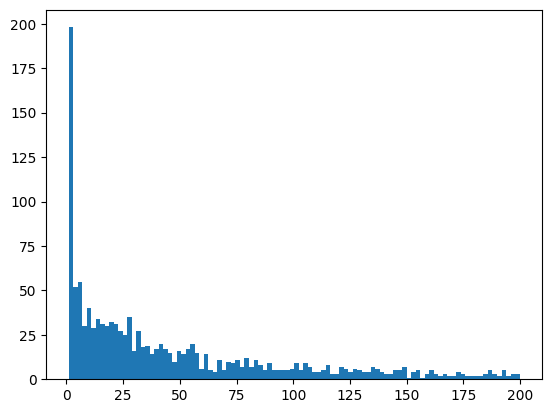

In [7]:
flattened = np.concatenate(ratios)
filtered = flattened[flattened < 200]

plt.hist(filtered, bins = 100)
plt.show()

In [10]:
muons._keys

array(['ProftTrack_5_4;1', 'ProflTrack_5_4;1',
       'Track_5_4_45_delta476_size43;1', 'ProftTrack_6_1;1',
       'ProflTrack_6_1;1', 'Track_6_1_17_delta360_size43;1',
       'ProftTrack_8_6;1', 'ProflTrack_8_6;1',
       'Track_8_6_4_delta403_size43;1', 'ProftTrack_10_4;1',
       'ProflTrack_10_4;1', 'Track_10_4_19_delta298_size41;1',
       'ProftTrack_15_0;1', 'ProflTrack_15_0;1',
       'Track_15_0_5_delta396_size43;1', 'ProftTrack_16_1;1',
       'ProflTrack_16_1;1', 'Track_16_1_51_delta563_size45;1',
       'ProftTrack_16_2;1', 'ProflTrack_16_2;1',
       'Track_16_2_11_delta304_size41;1', 'ProftTrack_17_2;1',
       'ProflTrack_17_2;1', 'Track_17_2_101_delta472_size45;1',
       'ProftTrack_20_0;1', 'ProflTrack_20_0;1',
       'Track_20_0_182_delta578_size44;1', 'ProftTrack_25_2;1',
       'ProflTrack_25_2;1', 'Track_25_2_32_delta299_size41;1',
       'ProftTrack_26_3;1', 'ProflTrack_26_3;1',
       'Track_26_3_17_delta421_size43;1', 'ProftTrack_28_3;1',
       'ProflTrack_28_